In [1]:
from fastai2.basics import *
from fastai2.vision.all import *

import kornia
from mish_cuda import MishCuda
import gc

from tqdm.notebook import tqdm

import astropy.io.ascii
from astropy.coordinates import SkyCoord, matching
import astropy.units as u

PATH = Path('../..').resolve()

%matplotlib inline

seed = 12345

In [2]:
torch.cuda.set_device('cuda:1')

# reproducability flags
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

item_tfms = []
batch_tfms = aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.)+[Normalize.from_stats(*image_stats)]

def root_mean_squared_error(preds, targs):  return torch.sqrt(F.mse_loss(preds.reshape(-1, 1), targs.reshape(-1, 1)))
def slope(p, y): return ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()

# Probing environment

In [4]:
a40A = pd.read_csv(f'{PATH}/data/final/a40A.csv')
overdensity = pd.read_csv(f'{PATH}/data/a.40-delta_5.csv', usecols=(1,2), index_col='AGCNr')

In [5]:
a40A = a40A.join(overdensity, on='AGCNr', how='inner')

## Conservative cut within SDSS footprint

In [8]:
in_box = (140 < a40A.RAdeg_OC) & (a40A.RAdeg_OC < 230)
sum(in_box)

5408

In [21]:
a40A = a40A[in_box]

In [61]:
# a40A.to_csv(f'{PATH}/results/final/a40A_delta_5.csv')

## Show cdf

In [23]:
overdensity.delta_5.quantile([0.01, 0.05, 0.16, 0.5, 0.84, 0.95, 0.99])

0.01     0.005919
0.05     0.086638
0.16     0.316823
0.50     1.068886
0.84     3.306099
0.95     7.399390
0.99    17.944082
Name: delta_5, dtype: float64

In [40]:
y_tot, x = np.histogram(np.log10(overdensity.delta_5), bins=100, range=[-3, 3])
y_a40A, _ = np.histogram(np.log10(a40A.delta_5), bins=100, range=[-3, 3])

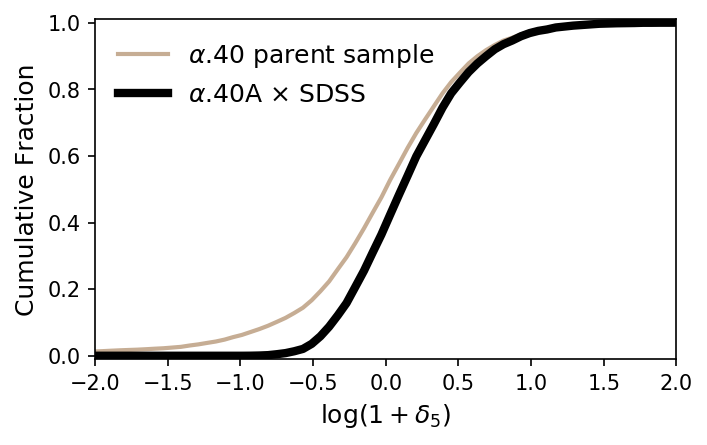

In [60]:
plt.figure(figsize=(5, 3), dpi=150)

plt.plot((x[:-1]+x[1:])/2, np.cumsum(y_tot)/sum(y_tot), c='#C6AD94', lw=2, label=r'$\alpha$.40 parent sample')
plt.plot((x[:-1]+x[1:])/2, np.cumsum(y_a40A)/sum(y_a40A), c='k', lw=4, label=r'$\alpha$.40A $\times$ SDSS')

plt.xlim(-2, 2);
plt.ylim(-0.01, 1.01);

plt.legend(fontsize=12, framealpha=0)

plt.xlabel(r'$\log(1+\delta_5)$', fontsize=12)
plt.ylabel(r'Cumulative Fraction', fontsize=12)

# plt.savefig(f'{PATH}/results/final/overdensity_cdf.pdf')

## Show some examples

In [4]:
a40A = pd.read_csv(f'{PATH}/results/final/a40A_delta_5.csv', dtype={'AGCNr': str})

In [5]:
a40A.sort_values(by='delta_5')[['AGCNr', 'delta_5']]

,AGCNr,delta_5
2493,225254,0.111872
4913,244938,0.128824
4397,242447,0.134323
3235,732366,0.137887
4329,242439,0.145961
...,...,...
753,200294,58.452186
2532,7201,58.652065
736,201117,60.971014
3412,735108,75.301014


In [6]:
# pipeline for processing images at a time
type_tfms = [PILImage.create]
item_tfms = [Resize(224), ToTensor()]
type_pipe = Pipeline(type_tfms)
item_pipe = Pipeline(item_tfms)
norm = Normalize.from_stats(*image_stats)
i2f = IntToFloatTensor()

# plotting kwargs
text_dict = dict(
    ha='center',
    color='white',
    fontsize=18
)

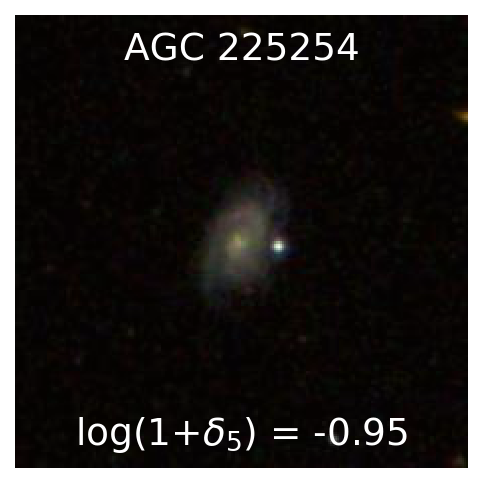

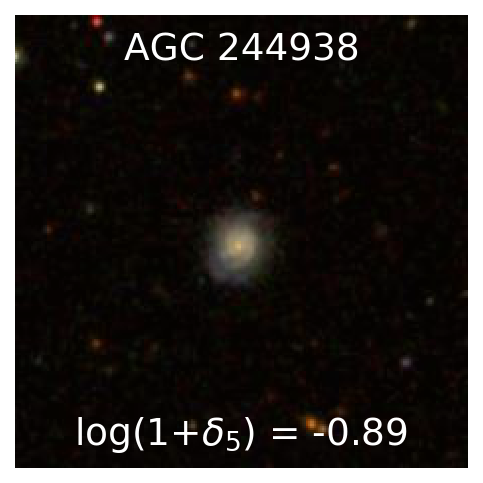

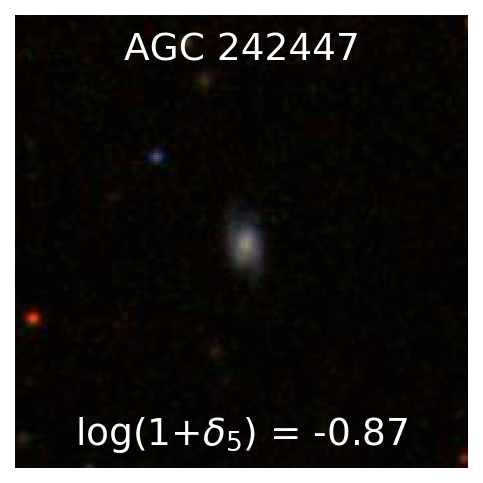

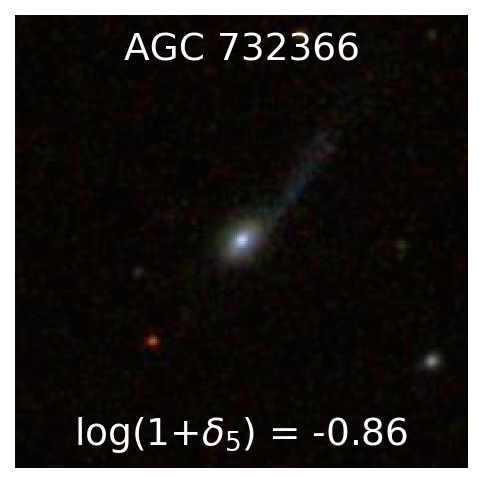

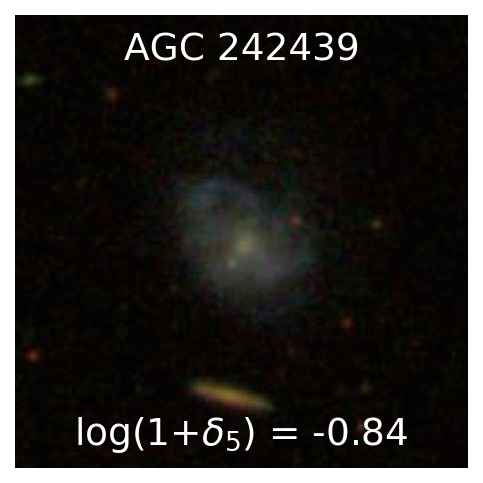

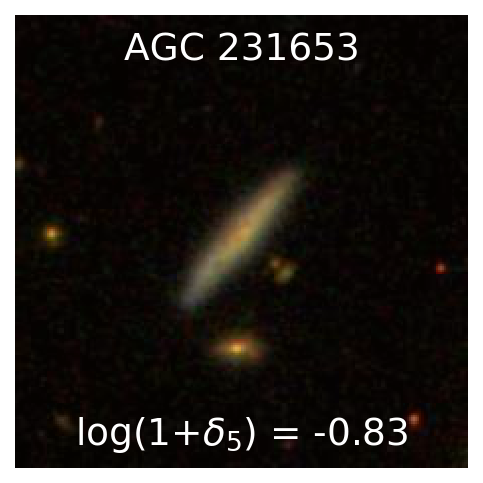

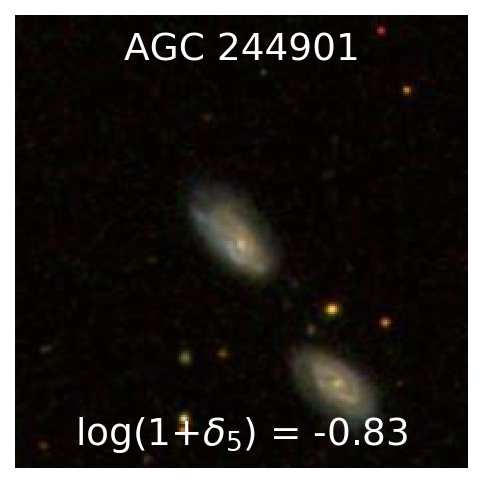

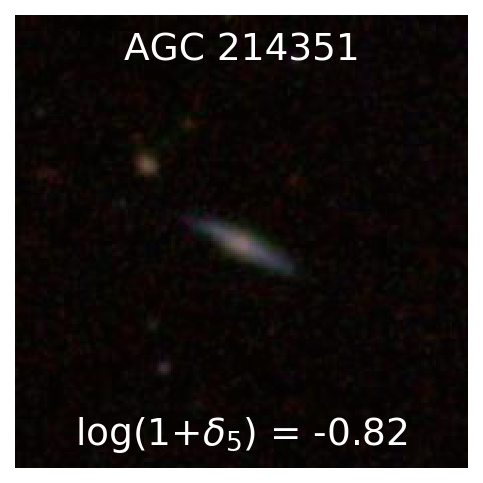

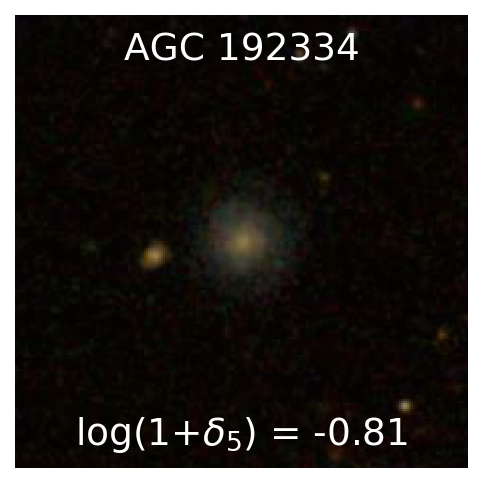

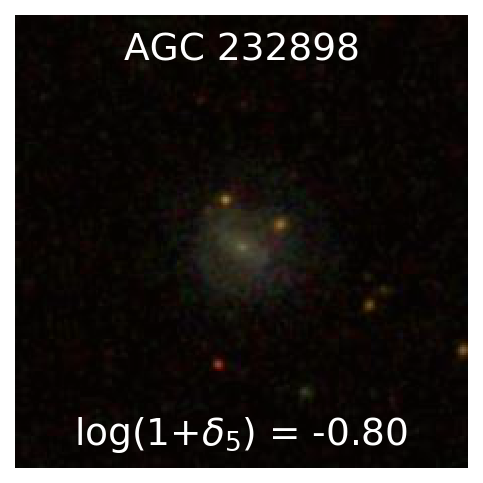

In [10]:
for _, [AGCNr, d5] in a40A.sort_values(by='delta_5')[['AGCNr', 'delta_5']][:10].iterrows():
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
    
    x = norm(i2f(item_pipe(type_pipe(f'{PATH}/images-OC/{AGCNr}.jpg')).cuda())).squeeze(0)
    x.show(ax=ax)

    ax.text(0.5, 0.9, f'AGC {AGCNr}', transform=ax.transAxes, **text_dict)
    ax.text(0.5, 0.05, f'log(1+$\delta_5$) = {np.log10(d5):.2f}', transform=ax.transAxes, **text_dict)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


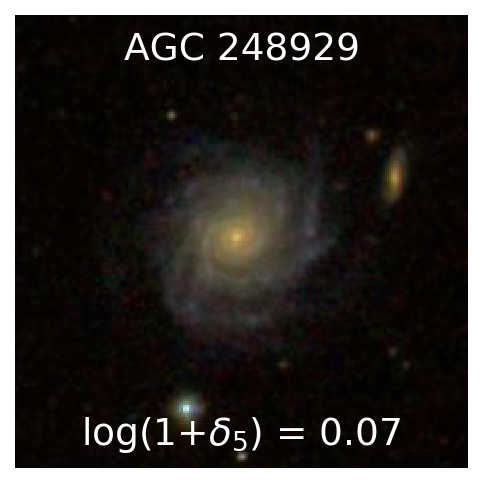

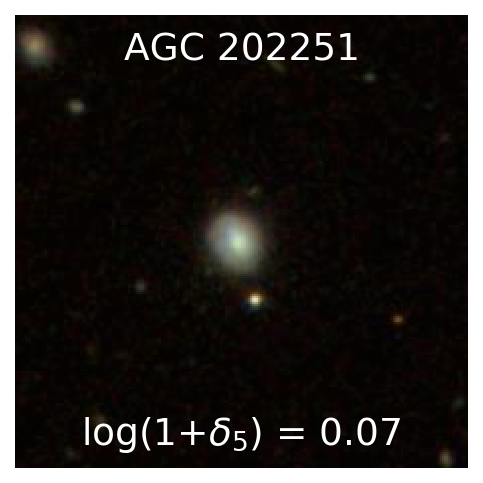

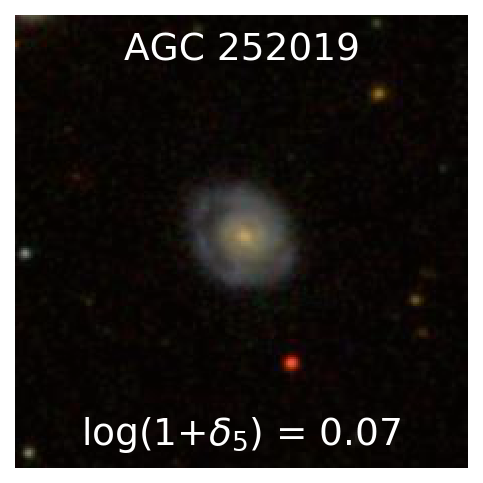

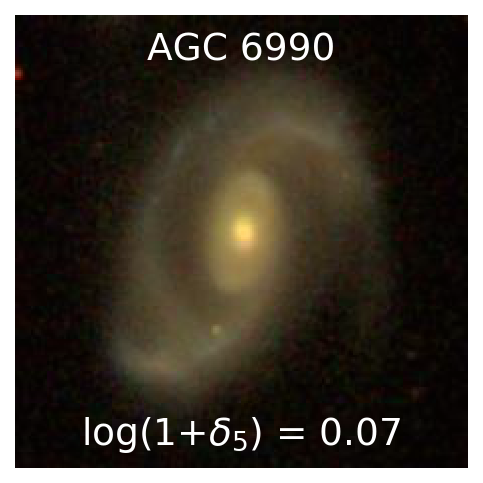

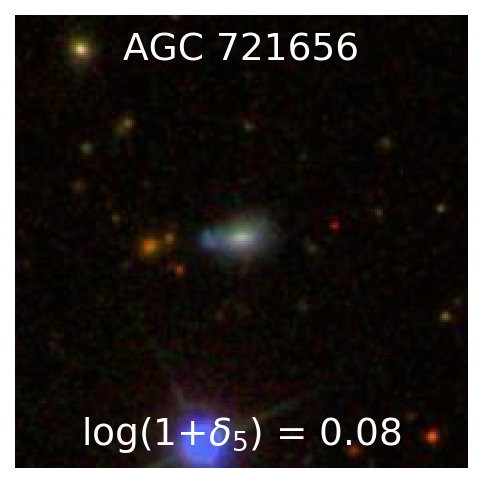

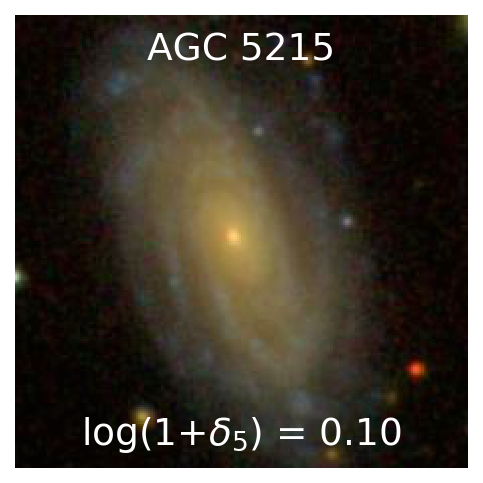

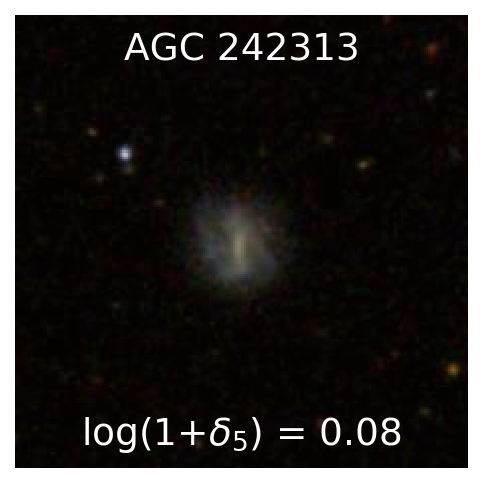

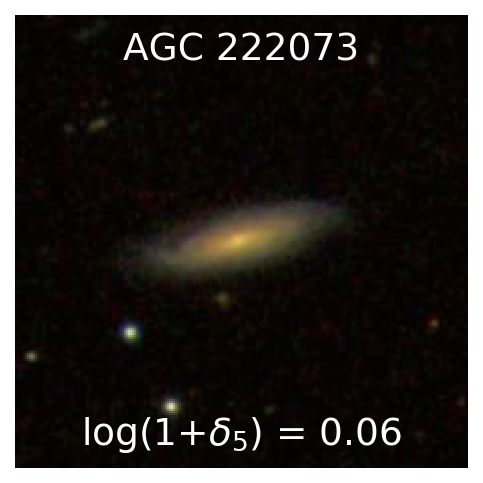

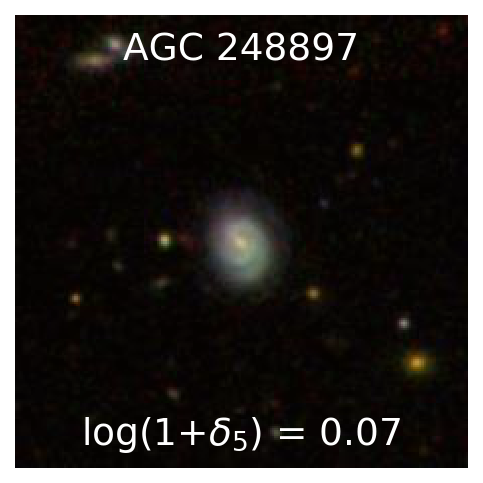

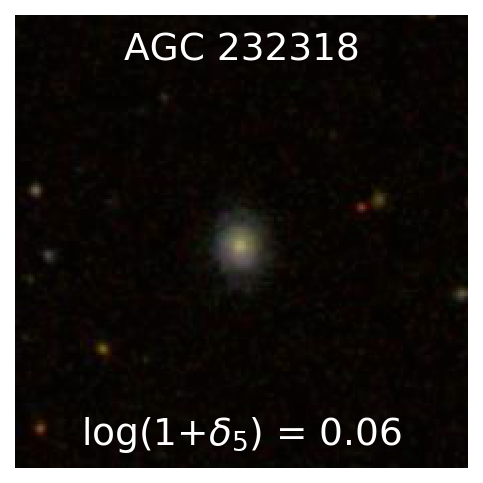

In [14]:
for _, [AGCNr, d5] in a40A.sort_values(by='delta_5')[['AGCNr', 'delta_5']][2300:2500].sample(10).iterrows():
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
    
    x = norm(i2f(item_pipe(type_pipe(f'{PATH}/images-OC/{AGCNr}.jpg')).cuda())).squeeze(0)
    x.show(ax=ax)

    ax.text(0.5, 0.9, f'AGC {AGCNr}', transform=ax.transAxes, **text_dict)
    ax.text(0.5, 0.05, f'log(1+$\delta_5$) = {np.log10(d5):.2f}', transform=ax.transAxes, **text_dict)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


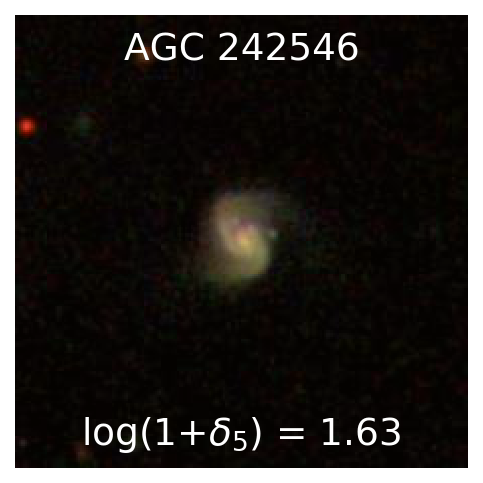

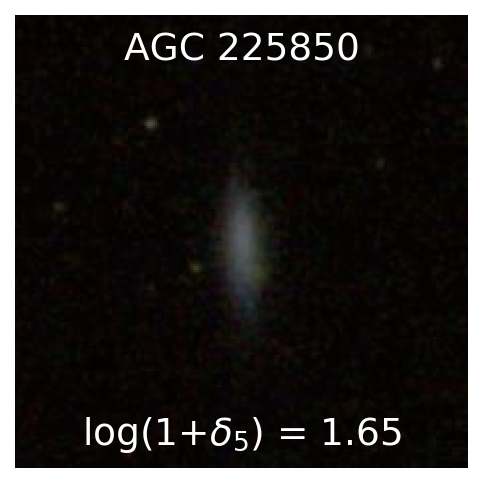

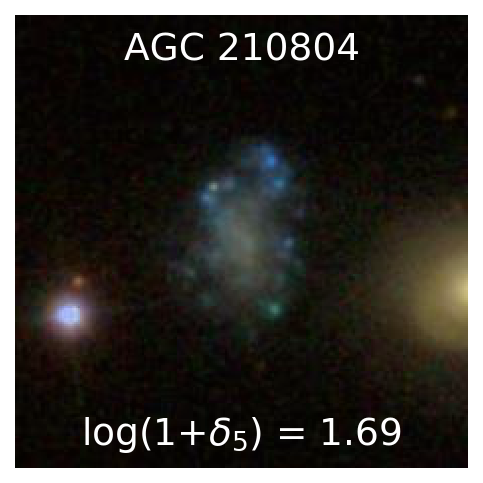

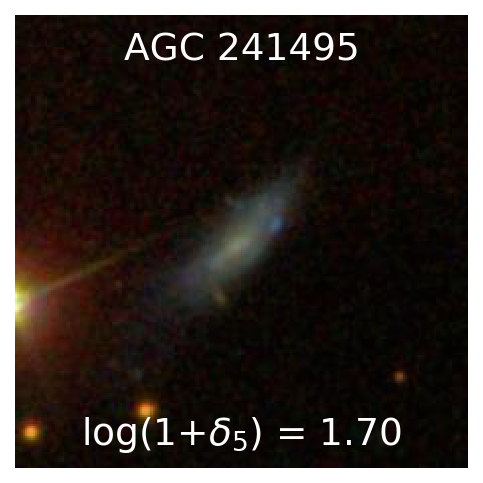

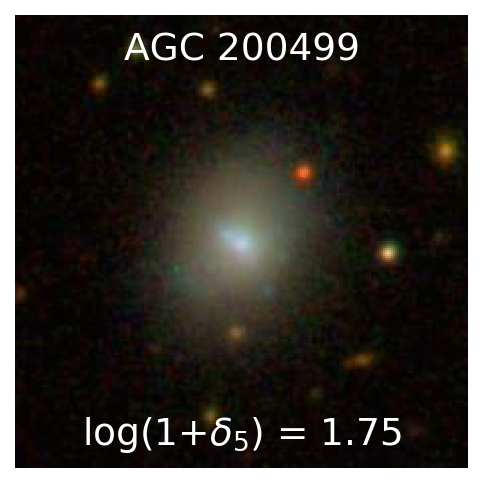

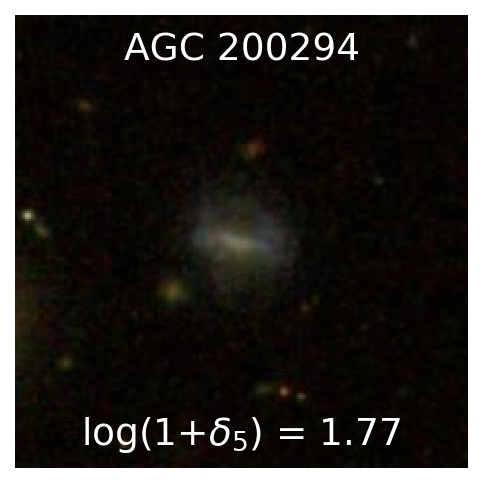

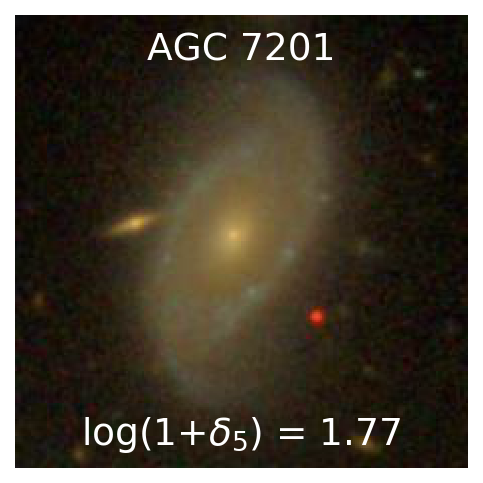

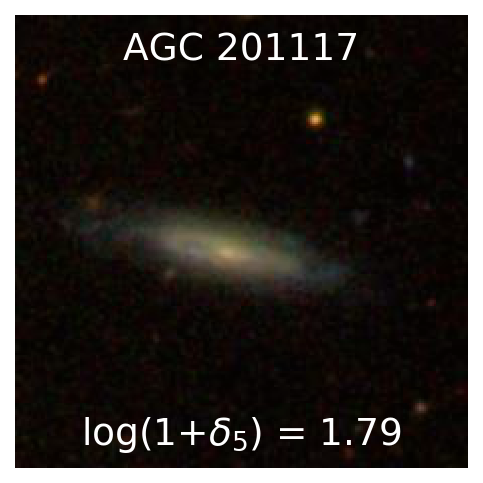

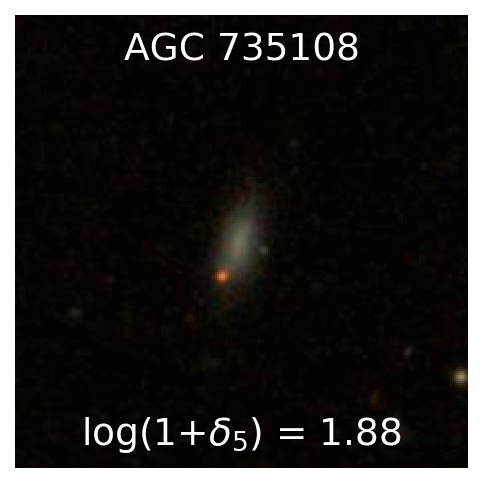

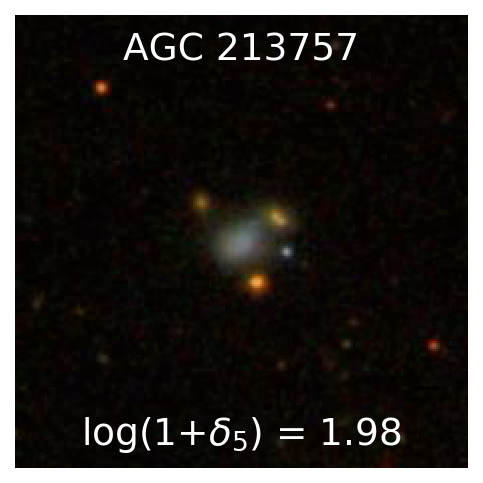

In [12]:
for _, [AGCNr, d5] in a40A.sort_values(by='delta_5')[['AGCNr', 'delta_5']][-10:].iterrows():
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
    
    x = norm(i2f(item_pipe(type_pipe(f'{PATH}/images-OC/{AGCNr}.jpg')).cuda())).squeeze(0)
    x.show(ax=ax)

    ax.text(0.5, 0.9, f'AGC {AGCNr}', transform=ax.transAxes, **text_dict)
    ax.text(0.5, 0.05, f'log(1+$\delta_5$) = {np.log10(d5):.2f}', transform=ax.transAxes, **text_dict)